### Aryl Halide Clustering
#### 1. Process dataset and remove highly correlated features (R2 > 0.95)
#### 2. Compare PCA and UMAP for dimensionality reduction and clustering
#### 3. Make optimal clusters and visualize molecules closest to cluster centers

In [1]:
import os

os.environ['NUMBA_DETERMINISTIC'] = '1'
os.environ['NUMBA_NUM_THREADS'] = '1'
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['BLIS_NUM_THREADS'] = '1'

os.environ['NUMBA_OPT'] = '0'
os.environ['NUMBA_DISABLE_JIT'] = '1'
os.environ['NUMBA_CPU_NAME'] = 'generic'
os.environ['NUMBA_DISABLE_INTEL_SVML'] = '1'
os.environ['NUMBA_ENABLE_AVX'] = '0'

In [2]:
# package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

# scikit learn!
import sklearn
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from scipy.spatial.distance import cdist

# umap for dimensionality reduction
import umap

# nice plotting
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

c:\Users\R9000P\.conda\envs\arylbr_linux\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


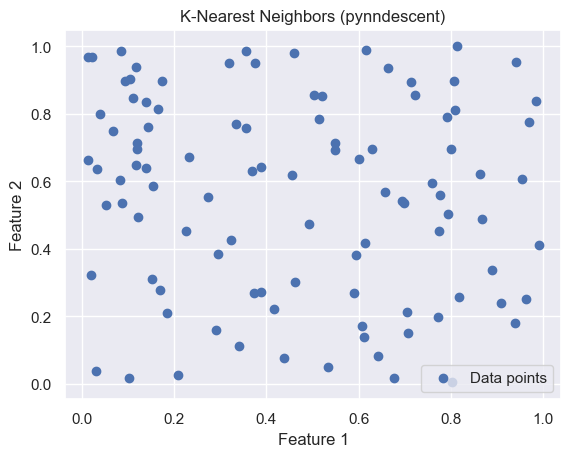

In [3]:
import pynndescent
# Set random seed for reproducibility
np.random.seed(42)
random_state = 42

# Sample Data: Replace this with your actual data
X_scaled = np.random.rand(100, 10)  # Generate random data for demonstration purposes

# Define the number of neighbors for KNN
n_neighbors = 10  # Adjust this based on your dataset

# Build the pynndescent index
index = pynndescent.NNDescent(
    X_scaled,
    n_neighbors=n_neighbors,
    metric='euclidean',
    random_state=random_state,
    n_jobs=1  # Limit to single-threaded execution
)

# Retrieve the neighbor graph (indices and distances)
knn_indices, knn_distances = index.neighbor_graph

# Perform a simple 2D projection (using the first two features for simplicity)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='b', label='Data points')

plt.title("K-Nearest Neighbors (pynndescent)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [4]:
# cleaned aryl X dataset
# We kept parameters for the low energy conformer (removing those for min/max and Bolztmann average, which are highly correlated)
arylx = pd.read_csv('arylx.csv')
arylx.head()

,id,smiles,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,ω_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,...,%Vbur_Br_2.5Å_low_E,%Vbur_C_3.0Å_low_E,%Vbur_Br_3.0Å_low_E,%Vbur_C_3.5Å_low_E,%Vbur_Br_3.5Å_low_E,%Vbur_C_4.0Å_low_E,%Vbur_Br_4.0Å_low_E,Sterimol_B1_C_Br(Å)_morfeus_low_E,Sterimol_B5_C_Br(Å)_morfeus_low_E,Sterimol_L_C_Br(Å)_morfeus_low_E
0,arbr141,Cc1[nH]nc(C(F)(F)F)c1Br,-0.30770,0.01581,0.32351,-0.145945,0.03292,43.1852,89.2019,5.5518,...,34.132048,78.811271,33.014563,68.080856,31.508572,56.128189,29.409255,2.277507,4.841637,4.126049
1,arbr142,Cc1[nH]nc(-c2ccccc2)c1Br,-0.27821,0.00248,0.28069,-0.137865,0.03386,102.7150,147.4390,2.8706,...,36.231931,77.875447,34.498845,67.397153,32.274390,55.776721,29.634644,2.077762,7.508006,4.136710
2,arbr143,Cc1cc(C(C)(C)C)cc(C)c1Br,-0.28384,0.01480,0.29864,-0.134520,0.03030,86.5084,162.0250,1.8175,...,36.599818,79.910980,35.651631,70.185543,33.763511,58.853811,30.847713,2.968765,4.479852,4.170312
3,arbr145,Cc1cccc(Cl)c1Br,-0.30209,-0.00082,0.30127,-0.151455,0.03807,69.3040,110.6700,2.6224,...,36.397968,79.426773,35.005401,69.397596,32.937127,57.807554,30.127708,1.868018,4.498470,4.153900
4,arbr146,Cc1cccc(F)c1Br,-0.30220,0.00107,0.30327,-0.150565,0.03738,62.0065,98.2669,2.6395,...,34.662716,78.545888,33.005252,67.583512,30.757315,55.012104,27.829201,1.850000,4.454212,4.152511


In [5]:
# the molecular descriptors
X = arylx.select_dtypes(include=['number'])

# set dtype to float64
X = X.astype('float32')

# trim significant figures to 3
X = X.round(3)

# Feature scaling through standardization (or Z-score normalization) is an important preprocessing step 
# for many machine learning algorithms. Standardization involves rescaling the features such that they 
# have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. 

X_scaled=pd.DataFrame(scale(X),index=X.index, columns=X.columns)

# drop zero-variance features
zero_std_cols = X_scaled.columns[X_scaled.std() == 0]
X_scaled=X_scaled[X_scaled.columns.difference(zero_std_cols)]
print (f"Dropping {len(zero_std_cols)} features {zero_std_cols}")

# drop highly correlated features
corr = X_scaled.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_scaled = X_scaled.drop(to_drop, axis=1)
print (f"Dropping {len(to_drop)} features {to_drop}")

Dropping 0 features Index([], dtype='object')
Dropping 10 features ['ω_low_E', 'SASA_surface_area(Å²)_low_E', 'SASA_volume(Å³)_low_E', 'pyramidalization_Gavrish_C(°)_low_E', '%Vbur_Br_2.5Å_low_E', '%Vbur_Br_3.0Å_low_E', '%Vbur_C_3.5Å_low_E', '%Vbur_Br_3.5Å_low_E', '%Vbur_C_4.0Å_low_E', '%Vbur_Br_4.0Å_low_E']


c:\Users\R9000P\.conda\envs\arylbr_linux\Lib\site-packages\sklearn\preprocessing\_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\R9000P\.conda\envs\arylbr_linux\Lib\site-packages\sklearn\preprocessing\_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [6]:
X_scaled.head()

,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,volume(Bohr_radius³/mol)_low_E,SASA_sphericity_low_E,NBO_charge_Br_low_E,...,pyramidalization_Agranat-Radhakrishnan_C_low_E,NBO_LP_energy_Br_low_E,NBO_LP_occupancy_Br_low_E,%Vbur_C_2.0Å_low_E,%Vbur_Br_2.0Å_low_E,%Vbur_C_2.5Å_low_E,%Vbur_C_3.0Å_low_E,Sterimol_B1_C_Br(Å)_morfeus_low_E,Sterimol_B5_C_Br(Å)_morfeus_low_E,Sterimol_L_C_Br(Å)_morfeus_low_E
0,-0.678474,1.672894,2.252083,0.751543,-1.580533,-1.507735,1.917315,-0.849583,1.123424,1.346344,...,-0.453525,-0.513093,1.226132,-0.139070,0.656542,0.887134,1.480228,1.197531,-0.633539,-0.255508
1,0.937642,1.076414,0.384873,1.202188,0.167396,-0.007780,0.020992,0.195476,0.093161,0.094426,...,4.298754,0.386669,1.945188,-0.208346,2.074224,0.358493,1.058018,0.368943,1.087855,-0.205884
2,0.614418,1.630288,1.166496,1.371179,-0.308476,0.367897,-0.723816,1.000580,0.056367,-1.822574,...,-0.453525,1.398903,0.363259,0.209503,1.640863,1.057912,1.976420,4.060303,-0.867276,-0.057016
3,-0.355250,0.948597,1.253343,0.469891,-0.813623,-0.954804,-0.155131,-0.935549,1.528171,0.133548,...,-0.453525,0.386669,-0.643415,0.174849,1.879682,0.973486,1.758097,-0.501075,-0.855654,-0.129196
4,-0.355250,1.033808,1.340190,0.469891,-1.027908,-1.274257,-0.142399,-0.932373,1.712147,0.055303,...,-0.453525,0.386669,-0.068178,0.356709,1.036189,0.817099,1.360692,-0.575648,-0.884064,-0.133707


#### At this point we have 22 descriptors remaining

In [11]:
# define the dimensionalities of the reduced representation to study
# We will compare the performance of clustering based on reduced dimensionality representations of size 3 and 2 dimensions
# Because tSNE cannot convert high dimension data, we only use size 3 and 3 dimensions
dims = [3, 2]

# dictionary to store data at different levels of dimensionality reduction
dfs={}

np.random.seed(42)

# UMAP
n_neighbors = int(np.sqrt(X_scaled.shape[1]))
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(umap.UMAP(n_epochs=10, n_components=2, n_neighbors=2, 
                                      random_state=np.random.RandomState(42), 
                                      init="pca", verbose=False, n_jobs=1
                                      ).fit_transform(X_scaled), index=X_scaled.index)

ValueError: n_neighbors must be greater than 1

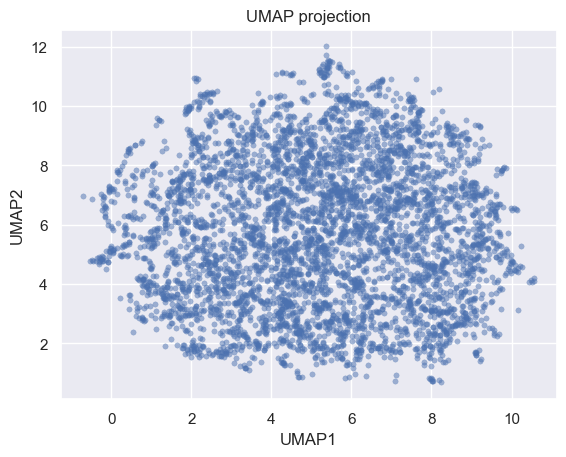

In [10]:
# plot the results
dfs["umap2"].rename(columns={0: "UMAP1", 1: "UMAP2"}, inplace=True)

sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    data=dfs["umap2"],
    s=15,
    alpha=0.5,
    linewidth=0.25,
    edgecolor="face",
).set_title("UMAP projection")

plt.show()